In [211]:
import geopandas as gpd
import xarray as xr
import numpy as np
import pandas as pd
# import matplotlib.cbook
# from matplotlib.cbook import boxplot_stat
from matplotlibconfig import basic
basic()

In [68]:
river= gpd.read_file('../mizuroute_file/reach.shp')
basins= gpd.read_file('../mizuroute_file/HRU.shp')
lake= gpd.read_file('../Houston_lake/NHDWaterBody.shp')

In [69]:
df_flow=pd.read_csv('../FlowID.txt')

In [70]:
pfaf_code_river= pd.read_csv('../mizuroute_file/pfaf_code_reach.csv').fillna(-9999).astype(int)
pfaf_code_basin= pd.read_csv('../mizuroute_file/pfaf_code_basin.csv').fillna(-9999).astype(int)

In [71]:
river['pfaf_code_1']= pfaf_code_river.pf_level_1.values.astype(str)
river['pfaf_code_2']= pfaf_code_river.pf_level_2.values.astype(str)
river['pfaf_code_3']= pfaf_code_river.pf_level_3.values.astype(str)
river['pfaf_code_4']= pfaf_code_river.pf_level_4.values.astype(str)
# basins['pfaf_code']= pfaf_code_basin.fillna(-9999).values.astype(int)

In [72]:
river['toCOMID']= [df_flow[df_flow.FROMCOMID==river.iloc[i].COMID].TOCOMID.values[0] for i in range(len(river))]

In [73]:
basins= basins[[True if basins.iloc[i].FEATUREID in river.COMID.values else False for i in range(len(basins))]]

bounds= river.total_bounds
river_atlas= gpd.read_file('/mnt/s/Projects/couple_mizuRoute/RiverATLAS_Data_v10_shp/RiverATLAS_v10_shp/RiverATLAS_v10_na.shp',mask=river)

river_atlas.to_file('/mnt/s/Projects/couple_mizuRoute/Houston_case/mizuroute_file/river_atlas.shp')

In [74]:
'''
Roughly estimate manning's coefficient using Strahler Stream Order from a look-up table

Courtesy Dr. Hassan Mashriqui

Source: proceedings.esri.com/library/userconf/proc16/papers/265_671.pdf

'''

order2n= {1:0.14,2:0.12,3:0.09,4:0.09,5:0.07,6:0.06,7:0.03,8:0.03,9:0.03,10:0.03}

river.loc[[False if river.toCOMID.iloc[i] in river.COMID.values else True for i in range(len(river))], 'toCOMID']= -9999

river.loc[[False if river.toCOMID.iloc[i] in river.COMID.values else True for i in range(len(river))], 'TerminalFl']= 1

river.to_file('../mizuroute_file/reach_wToID.shp')

In [75]:
river['lakeVol']= [lake.loc[lake.COMID==river.WBAREACOMI[i], 'LakeVolume'].values[0] if river.WBAREACOMI[i] in lake.COMID.values else 1 for i in range(len(river))]

In [76]:
river['LakeTar']=0

In [77]:
river.loc[river.lakeVol<0, 'lakeVol']= 1
river.loc[(river.lakeVol==0) & (river.LakeFract==1), 'lakeVol']= river.loc[river.LakeFract==1, 'lakeVol'].mean()
# river.loc[river.COMID==1439133, 'lakeVol']= 0.05998*(1609.34**3) / 4
river.loc[river.COMID==1440293, 'lakeVol']= 255330360/2
river.loc[river.COMID==1439137, 'lakeVol']= 255330360
river.loc[river.COMID==1439133, 'LakeTar']=1
river.loc[river.COMID==1440293, 'LakeTar']=1
river.loc[river.COMID==1439137, 'LakeTar']=1

In [19]:
lake= nc4.Dataset('/mnt/s/Models/mizuRoute-feature-mpi-pio/example/HDMA_lake/ancillary_data/ntopo_nldas_hdma_lake_D03.nc')

In [66]:
import netCDF4 as nc4

In [148]:
with nc4.Dataset('topology_network_Houston.nc', 'w', format='NETCDF4') as f:
    f.createDimension('seg', len(river))
    f.createDimension('hru', len(basins))
    f.createDimension('pfaf', 4)
    segID= f.createVariable('segId', 'i4', 'seg', fill_value=-9999)
    hruID= f.createVariable('HRUid', 'i4', 'hru', fill_value=-9999)
    downID= f.createVariable('downSegId', 'i4', 'seg', fill_value=-9999)
    lakeID= f.createVariable('lakeid', 'i8', 'seg', fill_value=-9999)
    slope= f.createVariable('slope', 'f8', 'seg', fill_value=-9999)
    length= f.createVariable('length', 'f8', 'seg', fill_value=-9999)
    mann= f.createVariable('man_n', 'f8', 'seg', fill_value=-9999)
    area= f.createVariable('area', 'f8', 'hru', fill_value=-9999)
    hruSegId=f.createVariable('hruSegId', 'i4', 'hru', fill_value=-9999)
    pfaf_code=f.createVariable('pfaf_code', 'S1', ('seg', 'pfaf'), fill_value=-9999)
    islake= f.createVariable('islake', 'i8', 'seg', fill_value=-9999)
    lake_storage= f.createVariable('D03_MaxStorage', 'f8', 'seg', fill_value=-9999)
    lake_coef=f.createVariable('D03_Coefficient', 'f8', 'seg', fill_value=-9999)
    lake_power=f.createVariable('D03_Power', 'f8', 'seg', fill_value=-9999)
    lake_type= f.createVariable('lakeModelType', 'i4', 'seg', fill_value=-9999)
    lake_tarVol=f.createVariable('lakeTargetVolume', 'i4', 'seg', fill_value=-9999)


    segID[:]= river.COMID.values
    hruID[:]= basins.GRIDCODE.values
    hruSegId[:]= basins.FEATUREID.values
    downID[:]=  river.toCOMID.values
    area[:]= (basins.AreaSqKM.values*1e6).astype(np.float32)
    slope[:]= river.SLOPE.values
    length[:]= (river.LENGTHKM.values*1000)
    mann[:]= river.StreamOrde.map(order2n).values
    pfaf_code[:]=  np.hstack([river.pfaf_code_1.values.reshape(-1,1), river.pfaf_code_2.values.reshape(-1,1),
                            river.pfaf_code_3.values.reshape(-1,1), river.pfaf_code_4.values.reshape(-1,1)])
    islake[:]= river.LakeFract.values
    lake_storage[:]= river.lakeVol.values
    lake_coef[:]= [1.15740741e-07*20 if river.iloc[i].LakeFract==1 else 0 for i in range(len(river))]
    lake_power[:]=[1.5 if river.iloc[i].LakeFract==1 else 0 for i in range(len(river))]
    lake_type[:]=[1 if river.iloc[i].LakeFract==1 else 0 for i in range(len(river))]
    lake_tarVol[:]=0
    lakeID[:]= [lake[lake.COMID==river.WBAREACOMI.iloc[i]].COMID.values[0] if len(lake[lake.COMID==river.WBAREACOMI.iloc[i]])>0 else 0 for i in range(len(river))]


# Water management data

In [41]:
addicks= pd.read_csv('../streamgauge/addicks.csv', converters={'datetime': pd.to_datetime})
addicks.set_index('datetime', inplace=True)

In [42]:
barker= pd.read_csv('../streamgauge/barker.csv', converters={'datetime':pd.to_datetime})
barker.set_index('datetime', inplace=True)

In [38]:
time= pd.date_range('201606010100', '201905312300', freq='H')

In [59]:
f= nc4.Dataset('water_management.nc', 'w', format='NETCDF4')
f.createDimension('seg', 3)
f.createDimension('time', len(time))
segID= f.createVariable('segId', 'i4', 'seg', fill_value=-9999)
lakeVol=f.createVariable('vol_wm', 'i4', ('time','seg'), fill_value=-9999)
t= f.createVariable('time', 'i4', 'time', fill_value=-9999)
t[:]= np.arange(len(t))
t.units= 'hours since 2016-06-01 01:00:00'
t.calendar= 'standard'
segID[:]= [1439133,1440293,1439137]
lakeVol[:,1]= barker.resample('H').mean().reindex(time).ffill().values.reshape(-1)
lakeVol[:,0]= addicks.resample('H').mean().reindex(time).ffill().values.reshape(-1)
lakeVol[:,2]= addicks.resample('H').mean().reindex(time).ffill().values.reshape(-1)
f.close

<function Dataset.close>

## Get runoff and subsurface runoff data

In [179]:
import pandas as pd
import rioxarray
from glob import glob

In [57]:
da= xr.open_rasterio('../ef5_1km/output_simu/runoff.20180601_0100.crest.tif')

In [58]:
sample= [da.rio.clip([basins.iloc[i].geometry], drop=False).values for i in range(len(basins))]

In [94]:
time= pd.date_range('201606010100', '201905312300', freq='H')
timeVar= xr.Variable('Time', time)
sur_runoff= xr.concat([xr.open_rasterio(t.strftime('../ef5_1km/output_simu/runoff.%Y%m%d_%H%M.crest.tif')) for t in time], dim=timeVar)

In [95]:
runoff= np.zeros((len(time), len(basins)), dtype=np.float32) * np.nan
for i in range(len(sample)):
    runoff[:, i]= sur_runoff.squeeze().where(sample[i]!=-9999.).mean(dim=['x','y']).values/1000.

In [96]:
del sur_runoff

In [97]:
sur_runoff= xr.concat([xr.open_rasterio(t.strftime('../ef5_1km/output_simu/subsurf.%Y%m%d_%H%M.crest.tif')) for t in time], dim=timeVar)

In [98]:
subrunoff= np.zeros((len(time), len(basins)), dtype=np.float32) * np.nan
for i in range(len(sample)):
    subrunoff[:, i]= sur_runoff.squeeze().where(sample[i]!=-9999.).mean(dim=['x','y']).values/1000.

In [99]:
runoff[np.isnan(runoff)]=0

In [100]:
subrunoff[np.isnan(subrunoff)]=0

In [101]:
ds_runoff= xr.Dataset(
    data_vars= {'runoff': (['time', 'HR_HRU'], runoff),
                'subrunoff': (['time', 'HR_HRU'], subrunoff),
                'hru': (['HR_HRU'],basins.GRIDCODE.values.astype(np.int32))},
    coords= {
        'time': time,
        'HR_HRU': np.arange(len(basins), dtype=np.int32)
    },
    attrs={'_FillValue': -9999.})

In [65]:
ds_runoff.fillna(-9999.).to_netcdf('Runoff.nc', encoding={'runoff': {'dtype': np.float32, '_FillValue': -9999},
                                                          'subrunoff': {'dtype': np.float32, '_FillValue': -9999},
                                                          'hru': {'dtype': np.int32, '_FillValue': -9999}})

In [266]:
f.close()

In [237]:
runoff[np.isnan(runoff)]=0
subrunoff[np.isnan(subrunoff)]=0

In [102]:
f= nc4.Dataset('Runoff.nc', 'w', format='NETCDF4')
f.createDimension('HR_HRU', len(basins))
f.createDimension('time', len(time))

hruID= f.createVariable('hru', 'i4', 'HR_HRU', fill_value=-9999)
surfq= f.createVariable('runoff', 'f8', ('time','HR_HRU'), fill_value=-9999)
subsurfq= f.createVariable('subrunoff', 'f8', ('time','HR_HRU'), fill_value=-9999)
# precip= f.createVariable('precip', 'f8', ('time','HR_HRU'), fill_value=-9999)
# evap= f.createVariable('evap', 'f8', ('time','HR_HRU'), fill_value=-9999)
t= f.createVariable('time', 'f8', 'time', fill_value=-9999)

surfq[:]= runoff
subsurfq[:]= subrunoff
surfq.units= 'mm/s'
subsurfq.units='mm/s'
hruID[:]= basins.GRIDCODE.values.astype(np.int32)
t[:]= np.arange(len(t))
t.units= 'hours since 2016-06-01 01:00:00'
t.calendar= 'standard'
# precip[:]= runoff
# precip.units= 'mm/s'
# evap[:]= runoff*0.5
# evap.units='mm/s'

f.close()

In [75]:
ds= xr.open_dataset('../ef5_1km_lake/houston.1000m.sub.lake.mizuRoute.h.2016-06-01-03600.nc')

# Outputs

In [1]:
from celluloid import Camera
from IPython.display import HTML
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
bounds= gpd.read_file('/mnt/s/Projects/WRF-CRESTiMAP/basin/Houston_basin.shp')

In [93]:
from netCDF4 import num2date, Dataset

## 1km grids w/o subsurface routing

In [98]:
df_lake

,time
0,2016-06-01 01:00:00
1,2016-06-01 02:00:00
2,2016-06-01 03:00:00
3,2016-06-01 04:00:00
4,2016-06-01 05:00:00
...,...
26274,2019-05-31 19:00:00
26275,2019-05-31 20:00:00
26276,2019-05-31 21:00:00
26277,2019-05-31 22:00:00


In [197]:
# with Dataset('houston.nhdplus.crest.lake.sub.mizuroute.h.2016-06-01-03600.nc', 'r') as nc:
#     time= pd.date_range(num2date(nc['time'][:][0], nc['time'].units).strftime('%Y%m%d%H%M'), num2date(nc['time'][:][-1], nc['time'].units).strftime('%Y%m%d%H%M'),
#                                    freq='H')
#     segID= nc['reachID'][:]
#     lake_mat= nc['IRFroutedRunoff'][:]

#     df_lake['Q']= nc['IRFroutedRunoff'][:].values
ds_lake= xr.open_mfdataset('houston.1000m.sub.lake.mizuroute.h.*.nc', concat_dim=['IRFroutedRunoff', 'IRFlakeVol']).load()
ds_nolake=xr.open_mfdataset('houston.1000m.sub.nolake.mizuroute.h.*.nc').load()
ds_nosub=xr.open_mfdataset('houston.1000m.nosub.nolake.mizuroute.h.*.nc').load()

In [9]:
gage= gpd.read_file('/mnt/s/Projects/couple_mizuroute/Houston_case/streamgauge/NHDPlus_streamgage.shp')

In [12]:
gage= gage[[reach in river.REACHCODE.values for reach in gage.REACHCODE]]

In [14]:
import os

In [15]:
gage= gage[[True if os.path.exists('../streamgauge/%s.csv'%_id) else False for _id in gage.SOURCE_FEA.values]]

In [6]:
import hydrostats.metrics as hm
import pandas as pd
import numpy as np

In [220]:
def calc_stat(ds, comid):
    print(gage.loc[gage.FLComID==comid].SOURCE_FEA.values[0])
    ts= pd.DataFrame(index=pd.to_datetime(ds.sel(time=slice('20170101','20190531')).time.values), columns=['obs', 'sim'])
    stn= pd.read_csv('../streamgauge/%s.csv'%gage.loc[gage.FLComID==comid].SOURCE_FEA.values[0], converters={'datetime':pd.to_datetime})
    stn.set_index('datetime', inplace=True)
    iseg= np.where(ds.reachID[0]==comid)[0]
    q= ds['IRFroutedRunoff'].sel(seg=iseg, time=slice('20170101','20190531'))
    ts.loc[pd.to_datetime(ds.sel(time=slice('20170101','20190531')).time.values),'sim']= q.values.reshape(-1)
    intersected_ind= ts.index.intersection(stn.index)
    ts.loc[intersected_ind, 'obs']=stn.loc[intersected_ind, 'discharge']
    ts=ts.astype(float).dropna()
    nash= hm.nse(ts.obs.values, ts.sim.values)
    kge= hm.kge_2009(ts.obs.values, ts.sim.values)

    return nash, kge

def get_ts(gage_id, reachID, time, mat):
    comid= gage.loc[gage.SOURCE_FEA==gage_id].FLComID.values
    print(comid)
    ts= pd.DataFrame(index=time, columns=['obs', 'sim'])
    stn= pd.read_csv('../streamgauge/%s.csv'%gage_id, converters={'datetime':pd.to_datetime})
    stn.set_index('datetime', inplace=True)
    iseg= np.where(reachID==comid)[0]
#     q= ds['IRFroutedRunoff'].sel(seg=iseg)
    ts.loc[time,'sim']= mat[:,iseg].filled(np.nan).reshape(-1)
    intersected_ind= ts.index.intersection(stn.index)
    ts.loc[intersected_ind, 'obs']=stn.loc[intersected_ind, 'discharge']
#     ts=ts.astype(float).dropna()
    return ts

In [239]:
ts= get_ts('08073500', segID, time, lake_mat)

[1439317]


In [199]:
for _id in gage.FLComID.values:
    nse,kge= calc_stat(ds_nosub, _id)
    gage.loc[gage.FLComID==_id, 'NSE_nosub']=nse
    gage.loc[gage.FLComID==_id, 'KGE_nosub']=kge

08076700
08074000
08072300
08075000
08074760
08075730
08075763
08075770
08072730
08075500
08074810
08073500
08074500
08073600
08073700
08075900
08076180
08074020
08076000
08072760
08076500
08074150


In [211]:
fig= plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
camera= Camera(fig)
for t in range(0,100*24,24):
    river['t']= ds.IRFroutedRunoff.isel(time=t).values
    cs=river.plot('t', legend=False, ax=ax, vmin=0, vmax=100, cmap='cool')
    bounds.plot(ax=ax,color='None',edgecolor='k')
    ax.text(0.5,1.01, ds.time.isel(time=t).dt.strftime('%Y%m%d').values, transform=ax.transAxes)
#     fig.colorbar(mappable=cs)
    camera.snap()
animation=camera.animate()
plt.close();

In [8]:
ds_sub= xr.open_dataset('houston.1000m.sub.h.2017-01-01-00000.nc')

In [240]:
np.where(ds_lake.reachID[0]==1439317)

(array([110]),)

In [247]:
import multiprocessing

In [ ]:
ax=gage.plot('KGE_sub', vmin=0, vmax=1, legend=True, figsize=(12,6))
for i in range(len(gage)):
    x=gage.LonSite.iloc[i];y=gage.LatSite.iloc[i]
    l=gage.SOURCE_FEA.iloc[i]
    ax.text(x,y,l)

## Gridded

In [201]:
for _id in gage.SOURCE_FEA.tolist():
    if os.path.exists('../ef5_1km/output_simu/ts.%s.crest.csv'%_id):
        df_res= pd.read_csv('../ef5_1km/output_simu/ts.%s.crest.csv'%_id)
        df_res= df_res.dropna()
        nash= hm.nse(df_res.iloc[:,1].values, df_res.iloc[:,2].values)
        kge= hm.kge_2009(df_res.iloc[:,1].values, df_res.iloc[:,2].values)
        gage.loc[gage.SOURCE_FEA==_id, 'NSE_gridded']= nash
        gage.loc[gage.SOURCE_FEA==_id, 'KGE_gridded']= kge

In [219]:
gage.drop('geometry', axis=1).to_csv('gage_metrics.csv')

In [ ]:
("#6B0077","#724E95","#7C7BB2","#8DA3CA","#A7C6DD","#C8E2EB","#F1F1F1")

In [292]:
from matplotlib.patches import Patch

[Text(1, 0, 'CREST'),
 Text(2, 0, 'CREST-VEC'),
 Text(3, 0, 'CREST-VEC+subq'),
 Text(4, 0, 'CREST-VEC+subq+lake')]

/home/allen/miniconda3/envs/wrf/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


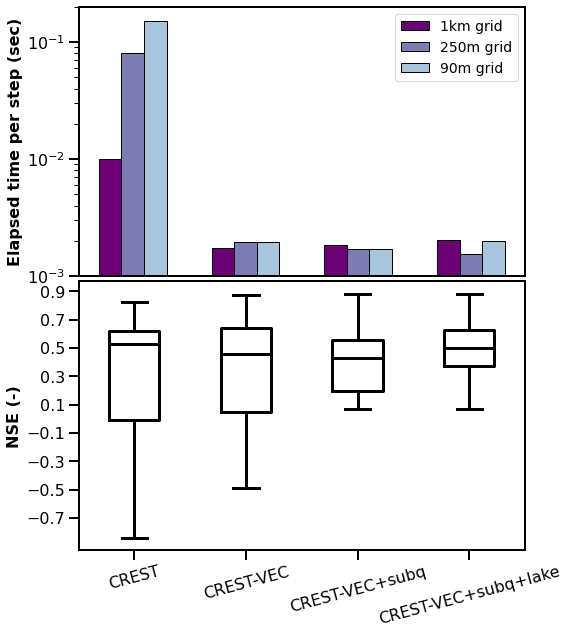

In [306]:
fig, axes= plt.subplots(2,1 ,figsize=(8,10), facecolor='white', gridspec_kw= {'hspace':0.02})
ax=axes[0]

ax.bar([0, 0.2, 0.4, 1, 1.2,1.4, 2, 2.2, 2.4, 3, 3.2, 3.4], [0.01, 0.08, 0.15, 
                                                             4.555734e01/2.627900e04, 5.158562e01/2.627900e04, 5.080883e01/2.627900e04,
                                                             4.877890e01/2.627900e04, 4.458733e01/2.627900e04, 4.445923e01/2.627900e04,
                                                             5.326006e01/2.627900e04, 4.046371e01/2.627900e04, 5.234855e01/2.627900e04],
       color=["#6B0077", "#7C7BB2", "#A7C6DD"]*4, width=0.2, edgecolor='k')
ax.set_xticks([])
# ax.set_yticks([0,1e-2,1e-1])
ax.set_ylim([1e-3,0.2])
ax.set_ylabel('Elapsed time per step (sec)')
ax.legend(handles=[Patch(facecolor='#6B0077', edgecolor='k', label='1km grid'),
          Patch(facecolor='#7C7BB2', edgecolor='k', label='250m grid'),
          Patch(facecolor='#A7C6DD', edgecolor='k', label='90m grid')])
# ax.set_xticklabels()
ax.set_yscale('log')
ax= axes[1]
ax.boxplot([gage.KGE_gridded.dropna(),  gage.KGE_nosub, gage.KGE_nolake, gage.KGE_lake], showfliers=False, whiskerprops = dict(linestyle='-',linewidth=3.0,
    color='black'), boxprops={'linewidth':3}, medianprops={'linewidth':3, 'color':'k'}, capprops={'linewidth':3})
ax.set_yticks(np.arange(-.7,1.0, 0.2))
ax.set_ylabel('NSE (-)')
ax.set_xticks([1,2,3,4]);
ax.set_xticklabels(['CREST', 'CREST-VEC', 'CREST-VEC+subq',   'CREST-VEC+subq+lake'], rotation=15)

In [307]:
fig.savefig('../figures/boxplot_houston.png', dpi=400)

/home/allen/miniconda3/envs/wrf/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """Entry point for launching an IPython kernel.


In [265]:
colors=("C0", "C1", "C2", "C3")

In [251]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.dates as mdates

/home/allen/miniconda3/envs/wrf/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


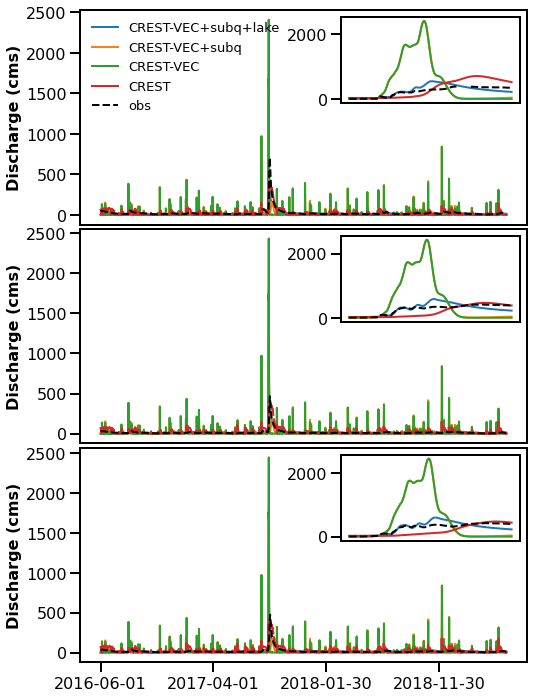

In [275]:
fig, axes= plt.subplots(3,1,figsize=(8,12), gridspec_kw={'hspace':0.02}, facecolor='white')
ax= axes[0]
gridded_ts= pd.read_csv('../ef5_1km/output_simu/ts.08073500.crest.csv', converters={'Time': pd.to_datetime}).set_index('Time')
gridded_ts= gridded_ts.loc[df_lake.time]
ax.plot(ds_lake.time, ds_lake.sel(seg=110).IRFroutedRunoff.values, label='CREST-VEC+subq+lake', color=colors[0])
ax.plot(ds_nolake.time, ds_nolake.sel(seg=110).IRFroutedRunoff.values, label='CREST-VEC+subq', color=colors[1])
ax.plot(ds_nosub.time, ds_nosub.sel(seg=110).IRFroutedRunoff.values, label='CREST-VEC', color=colors[2])
ax.plot(ds_lake.time, gridded_ts.iloc[:, 1], label='CREST', color=colors[3])
ax.plot(ds_lake.time, gridded_ts.iloc[:, 0], label='obs', color='k', linestyle='dashed')
ax.set_ylabel('Discharge (cms)')
ax.set_xticks([])
ax2= inset_axes(ax, loc='upper right', height='40%', width="40%")
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, ds_lake.sel(time=slice('20170825', '20170901'), seg=110).IRFroutedRunoff.values, color=colors[0])
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, ds_nolake.sel(time=slice('20170825', '20170901'), seg=110).IRFroutedRunoff.values, color=colors[1])
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, ds_nosub.sel(time=slice('20170825', '20170901'), seg=110).IRFroutedRunoff.values, color=colors[2])
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, gridded_ts.loc['20170825':'20170901'].iloc[:, 0], color=colors[3])
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, gridded_ts.loc['20170825':'20170901'].iloc[:, 1], color='k', linestyle='dashed')
ax2.set_xticks([])
ax.legend(loc='upper left', fontsize=13, frameon=False)

ax= axes[1]
gridded_ts= pd.read_csv('../ef5_1km/output_simu/ts.08073600.crest.csv', converters={'Time': pd.to_datetime}).set_index('Time')
gridded_ts= gridded_ts.loc[df_lake.time]
ax.plot(ds_lake.time, ds_lake.sel(seg=150).IRFroutedRunoff.values, label='CREST-VEC+subq+lake', color=colors[0])
ax.plot(ds_nolake.time, ds_nolake.sel(seg=150).IRFroutedRunoff.values, label='CREST-VEC+subq', color=colors[1])
ax.plot(ds_nosub.time, ds_nosub.sel(seg=150).IRFroutedRunoff.values, label='CREST-VEC', color=colors[2])
ax.plot(ds_lake.time, gridded_ts.iloc[:, 1], label='CREST', color=colors[3])
ax.plot(ds_lake.time, gridded_ts.iloc[:, 0], label='obs', color='k', linestyle='dashed')
ax.set_ylabel('Discharge (cms)')
ax.set_xticks([])
ax2= inset_axes(ax, loc='upper right', height='40%', width="40%")
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, ds_lake.sel(time=slice('20170825', '20170901'), seg=150).IRFroutedRunoff.values, color=colors[0])
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, ds_nolake.sel(time=slice('20170825', '20170901'), seg=150).IRFroutedRunoff.values, color=colors[1])
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, ds_nosub.sel(time=slice('20170825', '20170901'), seg=150).IRFroutedRunoff.values, color=colors[2])
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, gridded_ts.loc['20170825':'20170901'].iloc[:, 0], color=colors[3])
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, gridded_ts.loc['20170825':'20170901'].iloc[:, 1], color='k', linestyle='dashed')
ax2.set_xticks([])

ax= axes[2]
gridded_ts= pd.read_csv('../ef5_1km/output_simu/ts.08073700.crest.csv', converters={'Time': pd.to_datetime}).set_index('Time')
gridded_ts= gridded_ts.loc[df_lake.time]
ax.plot(ds_lake.time, ds_lake.sel(seg=226).IRFroutedRunoff.values, label='CREST-VEC+subq+lake', color=colors[0])
ax.plot(ds_nolake.time, ds_nolake.sel(seg=226).IRFroutedRunoff.values, label='CREST-VEC+subq', color=colors[1])
ax.plot(ds_nosub.time, ds_nosub.sel(seg=226).IRFroutedRunoff.values, label='CREST-VEC', color=colors[2])
ax.plot(ds_lake.time, gridded_ts.iloc[:, 1], label='CREST', color=colors[3])
ax.plot(ds_lake.time, gridded_ts.iloc[:, 0], label='obs', color='k', linestyle='dashed')
ax.set_ylabel('Discharge (cms)')
ax.set_xticks(ds_lake.time[::365*20])
ax2= inset_axes(ax, loc='upper right', height='40%', width="40%")
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, ds_lake.sel(time=slice('20170825', '20170901'), seg=226).IRFroutedRunoff.values, color=colors[0])
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, ds_nolake.sel(time=slice('20170825', '20170901'), seg=226).IRFroutedRunoff.values, color=colors[1])
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, ds_nosub.sel(time=slice('20170825', '20170901'), seg=226).IRFroutedRunoff.values, color=colors[2])
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, gridded_ts.loc['20170825':'20170901'].iloc[:, 0], color=colors[3])
ax2.plot(ds_lake.sel(time=slice('20170825', '20170901')).time, gridded_ts.loc['20170825':'20170901'].iloc[:, 1], color='k', linestyle='dashed')
ax2.set_xticks([]);

In [276]:
fig.savefig('../figures/ts.lake.png', dpi=400)

/home/allen/miniconda3/envs/wrf/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """Entry point for launching an IPython kernel.


## No-lake routing

In [159]:
ds= xr.open_mfdataset('houston.1000m.sub.nolake.mizuroute.h.*.nc', concat_dim='time', data_vars=['IRFroutedRunoff'])

In [162]:
ds['IRFroutedRunoff'].max().values

array(7538.3955, dtype=float32)

In [110]:
for _id in gage.FLComID.values:
    nse,kge= calc_stat(_id)
    gage.loc[gage.FLComID==_id, 'NSE_nolake']=nse
    gage.loc[gage.FLComID==_id, 'KGE_nolake']=kge

08076700
08074000
08072300
08075000
08074760
08075730
08075763
08075770
08072730
08075500
08074810
08073500
08074500
08073600
08073700
08075900
08076180
08074020
08076000
08072760
08076500
08074150


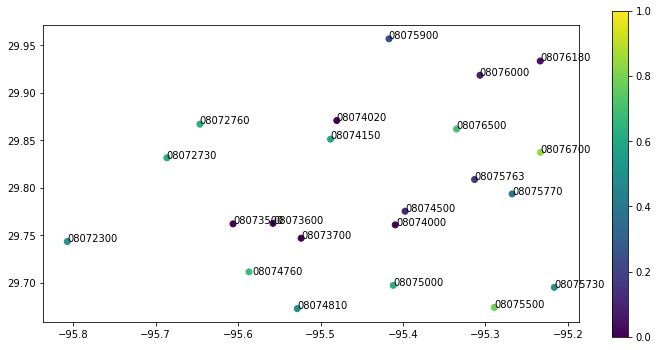

In [112]:
ax=gage.plot('KGE_nolake', vmin=0, vmax=1, legend=True, figsize=(12,6))
for i in range(len(gage)):
    x=gage.LonSite.iloc[i];y=gage.LatSite.iloc[i]
    l=gage.SOURCE_FEA.iloc[i]
    ax.text(x,y,l)

<AxesSubplot:>

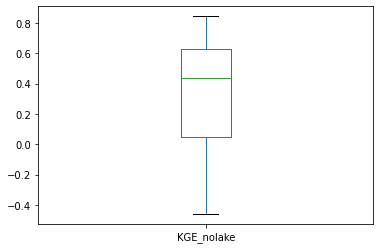

In [113]:
gage.KGE_nolake.plot(kind='box')

In [183]:
ds= xr.open_dataset('/mnt/s/Models/mizuRoute-feature-mpi-pio/example/HDMA_lake/output/test/lake_test.mizuroute.h.1980-01-01-00000.nc')

In [187]:
ds.IRFlakeVol.values

array([[      0.   ,       0.   ,       0.   , ...,   79923.3  ,
          52579.656,   80332.71 ],
       [      0.   ,       0.   ,       0.   , ...,  405706.1  ,
         219299.53 ,  311775.25 ],
       [      0.   ,       0.   ,       0.   , ..., 1062266.5  ,
         499577.1  ,  675795.56 ]], dtype=float32)